# KKBOX Churn Prediction Memory Reduction & EDA.

**Objective :**  Predicting whether a user will churn after the subscription expires.

***KKBOX*** is Asia's leading music streaming service, holding the world's most comprehensive Asia-Pop music library with over 30 million tracks, supported by advertising and paid subscriptions. Currently, the company uses survival analysis techniques to determine the residual membership life time for each subscriber. By adopting different methods, KKBOX anticipates they'll discover new insights to why users leave so they can be proactive in retaining users.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
import datetime
from scipy import stats
%matplotlib inline

**train_v2csv:** The train set, containing the user ids and whether they have churned.

**transactions.csv:** The transaction set contains all the payment details till feb-2017.

**transactions_v2csv:** The transaction set contains all the payment details of march-2017.

**members.csv:** The members set contains the user information.

**user_logs.csv:** The user logs set contains the daily user logs describing listening behaviors of a user for the month march-2017.

In [2]:
members = pd.read_csv('/Users/dineshviswatejagurram/Desktop/members_v3.csv') 
transactions_1 = pd.read_csv('/Users/dineshviswatejagurram/Desktop/transactions.csv') 
transactions = transactions_1.append(pd.read_csv('/Users/dineshviswatejagurram/Desktop/transactions_v2.csv') )
user_logs = pd.read_csv('/Users/dineshviswatejagurram/Desktop/user_logs_v2.csv')
train = pd.read_csv('/Users/dineshviswatejagurram/Desktop/train_v2.csv')

# Checking each file's memory usage

In [3]:
print('members memory-usage : ' + str(members.memory_usage().sum()/1023**2) + " MB")
print('transactions memory-usage : ' + str(transactions.memory_usage().sum()/1023**2) + " MB")
print('user-logs memory-usage : ' + str(user_logs.memory_usage().sum()/1023**2) + " MB")
print('train memory-usage : ' + str(train.memory_usage().sum()/1023**2) + " MB")

members memory-usage : 310.488083942251 MB
transactions memory-usage : 1756.5690009545842 MB
user-logs memory-usage : 1265.6487722748248 MB
train memory-usage : 14.844729577489014 MB


# Members data set

In [4]:
print(members.info()) 
members.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
dtypes: int64(4), object(2)
memory usage: 309.9+ MB
None


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


Since 'registration_init_time' and 'expiration_date' columns are not datetime type. First, we will split them based on year, month, and date in order to convert it to more convinent type for us in the later data analysis.

In [5]:
members['registration_init_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[:4]))
members['registration_init_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['registration_init_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[-2:]))

members['registration_init_year'] = members['registration_init_year'].astype(np.int16)
members['registration_init_month'] = members['registration_init_month'].astype(np.int8)
members['registration_init_date'] = members['registration_init_date'].astype(np.int8)

members['city'] = members['city'].astype(np.int8)
members['bd'] = members['bd'].astype(np.int16)
members['registered_via'] = members['registered_via'].astype(np.int8)
members['registration_init_year'] = members['registration_init_year'].astype(np.int16)
members['registration_init_month'] = members['registration_init_month'].astype(np.int8)
members['registration_init_date'] = members['registration_init_date'].astype(np.int8)

members = members.drop('registration_init_time', 1)

print(members.memory_usage().sum()/1023**2,"MB")

155.24408019271326 MB


In [6]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_year,registration_init_month,registration_init_date
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011,9,11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011,9,14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011,9,15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011,9,15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011,9,15


Members file memory usage reduced from 310 MB to 155 MB

# Transactions data set

In [7]:
print(transactions.info())
transactions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22978755 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.7+ GB
None


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [8]:
transactions['transaction_date_year'] = transactions['transaction_date'].apply(lambda x: int(str(x)[:4]))
transactions['transaction_date_month'] = transactions['transaction_date'].apply(lambda x: int(str(x)[4:6]))
transactions['transaction_date_date'] = transactions['transaction_date'].apply(lambda x: int(str(x)[-2:]))

transactions['membership_expire_date_year'] = transactions['membership_expire_date'].apply(lambda x: int(str(x)[:4]))
transactions['membership_expire_date_month'] = transactions['membership_expire_date'].apply(lambda x: int(str(x)[4:6]))
transactions['membership_expire_date_date'] = transactions['membership_expire_date'].apply(lambda x: int(str(x)[-2:]))

transactions['transaction_date_year'] = transactions['transaction_date_year'].astype(np.int16)
transactions['transaction_date_month'] = transactions['transaction_date_month'].astype(np.int8)
transactions['transaction_date_date'] = transactions['transaction_date_date'].astype(np.int8)

transactions['membership_expire_date_year'] = transactions['membership_expire_date_year'].astype(np.int16)
transactions['membership_expire_date_month'] = transactions['membership_expire_date_month'].astype(np.int8)
transactions['membership_expire_date_date'] = transactions['membership_expire_date_date'].astype(np.int8)

transactions['payment_method_id'] = transactions['payment_method_id'].astype(np.int8)
transactions['payment_plan_days'] = transactions['payment_plan_days'].astype(np.int16)
transactions['plan_list_price'] = transactions['plan_list_price'].astype(np.int16)
transactions['actual_amount_paid'] = transactions['actual_amount_paid'].astype(np.int16)
transactions['is_auto_renew'] = transactions['is_auto_renew'].astype(np.int8)
transactions['is_cancel'] = transactions['is_cancel'].astype(np.int8)

transactions = transactions.drop('transaction_date', 1)
transactions = transactions.drop('membership_expire_date', 1)

print(transactions.memory_usage(index=True).sum()/ 1024**2," MB")

723.1701993942261  MB


In [9]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,transaction_date_year,transaction_date_month,transaction_date_date,membership_expire_date_year,membership_expire_date_month,membership_expire_date_date
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,0,2015,9,30,2015,11,1
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,0,2015,9,30,2015,10,31
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,0,2015,9,30,2016,4,27
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,0,2015,9,30,2015,11,28
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,0,2015,9,30,2015,11,21


transactions file memory usage reduced from 1756 MB to 723 MB

# User logs dataset

In [10]:
print(user_logs.info())
user_logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18396362 entries, 0 to 18396361
Data columns (total 9 columns):
msno          object
date          int64
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ GB
None


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


In [11]:
user_logs['date_year'] = user_logs['date'].apply(lambda x: int(str(x)[:4]))
user_logs['date_month'] = user_logs['date'].apply(lambda x: int(str(x)[4:6]))
user_logs['date_date'] = user_logs['date'].apply(lambda x: int(str(x)[-2:]))

user_logs['date_year'] = user_logs['date_year'].astype(np.int16)
user_logs['date_month'] = user_logs['date_month'].astype(np.int8)
user_logs['date_date'] = user_logs['date_date'].astype(np.int8)

user_logs['num_25'] = user_logs['num_25'].astype(np.int16)
user_logs['num_50'] = user_logs['num_50'].astype(np.int16)
user_logs['num_75'] = user_logs['num_75'].astype(np.int16)
user_logs['num_985'] = user_logs['num_985'].astype(np.int16)
user_logs['num_100'] = user_logs['num_100'].astype(np.int32)
user_logs['num_unq'] = user_logs['num_unq'].astype(np.int16)

user_logs = user_logs.drop('date', 1)

print(user_logs.memory_usage().sum()/1023**2,"MB")

597.6675161414543 MB


In [12]:
user_logs.head()

,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,date_year,date_month,date_date
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,8,4,0,1,21,18,6309.273,2017,3,31
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2,2,1,0,9,11,2390.699,2017,3,30
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,52,3,5,3,84,110,23203.337,2017,3,31
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,176,4,2,2,19,191,7100.454,2017,3,31
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,2,1,0,1,112,93,28401.558,2017,3,31


user logs file memory usage reduced from 1265 MB to 596 MB

# Train dataset

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970960 entries, 0 to 970959
Data columns (total 2 columns):
msno        970960 non-null object
is_churn    970960 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.8+ MB


In [14]:
train['is_churn'] = train['is_churn'].astype(np.int8)

print(train.memory_usage().sum()/1023**2,"MB")

8.350193831226846 MB


train file memory usage reduced from 14 MB to 8 MB

# Churn Percentage

Churn Percentage: 8.994191315811156


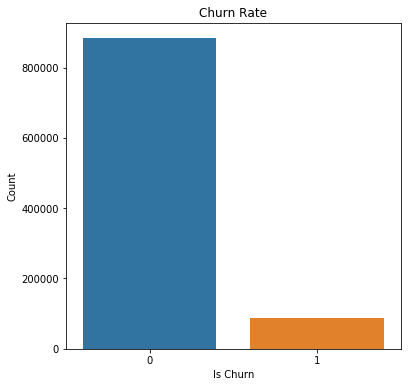

In [15]:
plt.figure(figsize=(6,6))
sns.countplot(x="is_churn", data=train)
print('Churn Percentage: ' + str(87330/970960 * 100))
plt.title('Churn Rate')
plt.xlabel('Is Churn')
plt.ylabel('Count')
plt.savefig('Churn Percentage.png')

Only 9% people have churned which looks so successful, making it a highly imbalanced classification problem.

# Data Exploration in x1 (merged data set of train and members)

In [16]:
x1 = pd.merge(train,members, on='msno', how='left')

In [17]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 9 columns):
msno                       970960 non-null object
is_churn                   970960 non-null int8
city                       860967 non-null float64
bd                         860967 non-null float64
gender                     388905 non-null object
registered_via             860967 non-null float64
registration_init_year     860967 non-null float64
registration_init_month    860967 non-null float64
registration_init_date     860967 non-null float64
dtypes: float64(6), int8(1), object(2)
memory usage: 67.6+ MB


Because not all users are present in the members data set, we are seeing some null values in x1.

# Which city are the users coming from & Which city users are churning most?

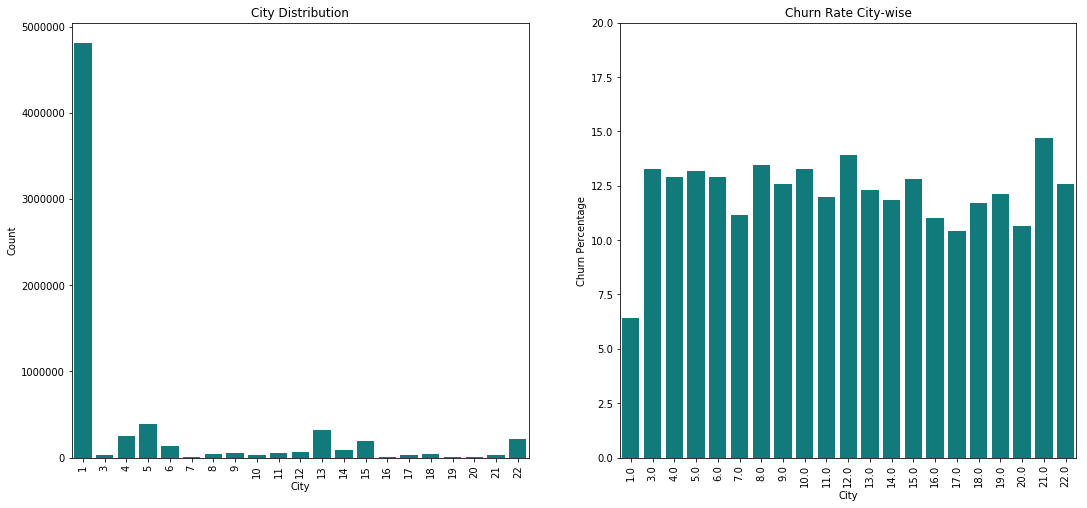

In [18]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.countplot(x="city", data=members, color = 'darkcyan')
plt.xlabel('City')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('City Distribution')

plt.subplot(122)
a = x1.groupby(['city','is_churn'])['msno'].count().reset_index()
a = pd.pivot_table(a, values='msno', index='city',columns='is_churn')
a['city_churn_percentage'] = (a[1]/(a[0] + a[1]))*100
a = a.reset_index()
sns.barplot(x = 'city', y = 'city_churn_percentage',data = a, color = 'darkcyan')
plt.ylim(0, 20)
plt.title('Churn Rate City-wise')
plt.xlabel('City')
plt.ylabel('Churn Percentage')
plt.xticks(rotation = 90)
plt.savefig('City Distribution.png')
plt.show()

There are total of 21 cities, there is no city '2'. We observe majority from city 1. Everything else looks similarly unpopular.

The cities are quite similar at churn rates with the crucial exception of city “1”. In this most popular city (see above) the churn rate is significantly lower when compared to other cities. This has a big impact on the overall churn rate.

# How is the users age distributed? (members)

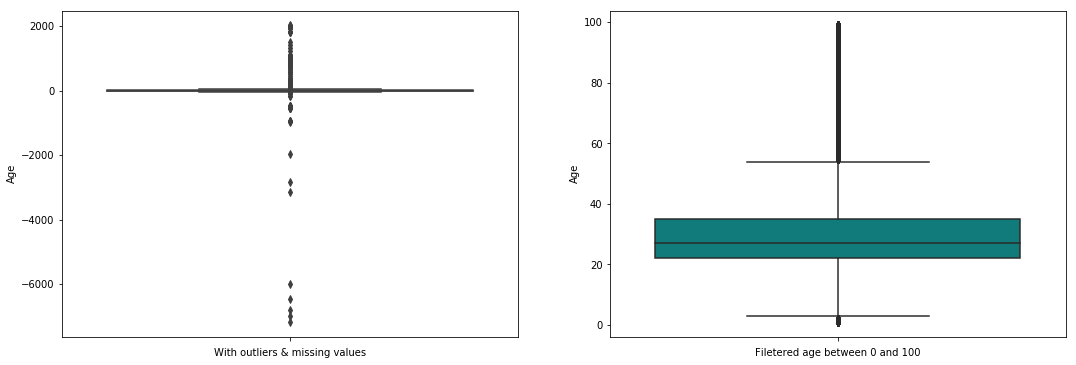

In [19]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
sns.boxplot(y = members.bd, data = members)
plt.xlabel('With outliers & missing values')
plt.ylabel('Age')
plt.subplot(1,2,2)
filtered_bd =members.bd[(members.bd > 0 )& (members.bd < 100)] 
sns.boxplot(y = filtered_bd, data = members, color = 'darkcyan')
plt.xlabel('Filetered age between 0 and 100')
plt.ylabel('Age')
plt.savefig('Age-outliers.png')
plt.show()

Here in the bd (Age) column we observed it has lot of values set to 0 and there are some outliers.

## Age Distribution

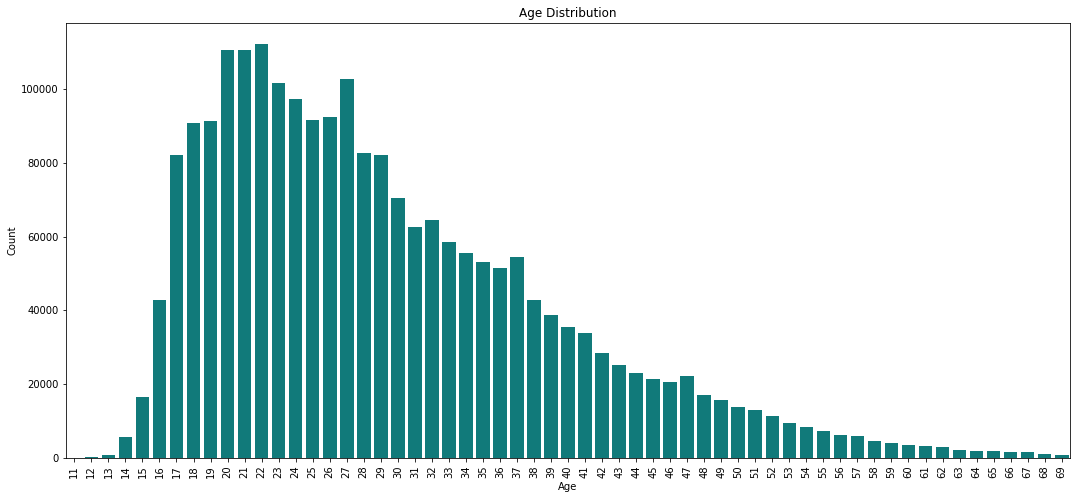

In [20]:
plt.figure(figsize = (18,8))
filtered_bd =members.bd[(members.bd > 10 )& (members.bd < 70)] 
sns.countplot(filtered_bd, color = 'darkcyan')
plt.xticks(rotation = 90)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.savefig('Age Distribution.png')
plt.show()

Here we filtered the bd (Age) column between 10 and 70 and from the above distribution we can clearly see that most of the customers are aged betweem mid teen's to mid 40's.

# Which age group users are churning most? (x1)

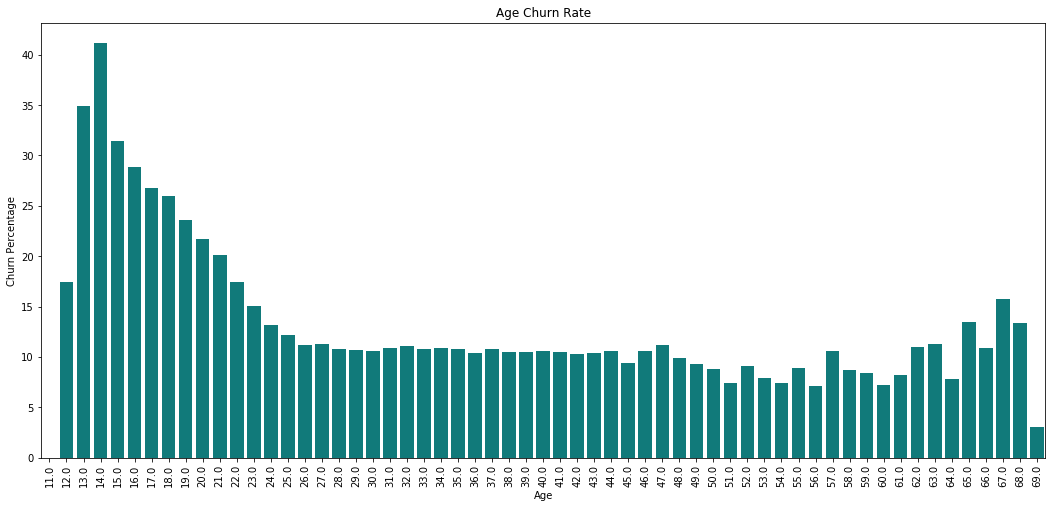

In [21]:
plt.figure(figsize = (18,8))
filtered_bd_x1 =x1[(x1.bd > 10 )& (x1.bd < 70)] 

b = filtered_bd_x1.groupby(['bd','is_churn'])['msno'].count().reset_index()
b = pd.pivot_table(b, values='msno', index='bd',columns=['is_churn'])
b['age_churn_percentage'] = (b[1]/(b[0] + b[1]))*100
b = b.reset_index()
sns.barplot(x = 'bd', y = 'age_churn_percentage',data = b, color = 'darkcyan')
plt.xticks(rotation = 90)
plt.xlabel('Age')
plt.ylabel('Churn Percentage')
plt.title('Age Churn Rate')
plt.savefig('Age Churn Rate.png')
plt.show()

Here we are only visualizing the churn rates of users between 10 and 70 and we find that younger users on average appear to be more likely to churn.



# Male Vs Female. 
# Who is registering more ? Who is churning more ? (members & x1)

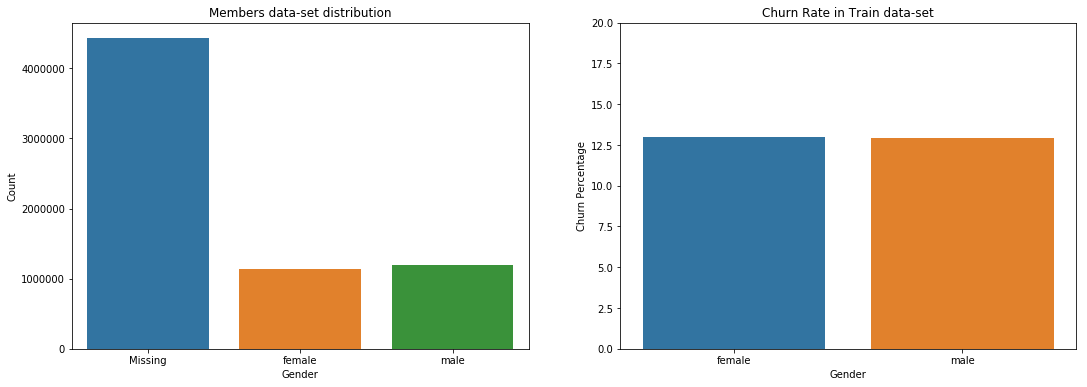

In [22]:
members['gender'] = members['gender'].fillna('Missing')
plt.figure(figsize=(18,6))
plt.subplot(121)
sns.countplot(x="gender", data=members)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Members data-set distribution')

plt.subplot(122)
c = x1.groupby(['gender', 'is_churn'])['msno'].count().reset_index()
c = pd.pivot_table(c, index = 'gender', columns = 'is_churn', values = 'msno')
c['gender_churn_percentage'] = (c[1]/ (c[0] + c[1])) * 100
c = c.reset_index()
sns.barplot(x = 'gender', y = 'gender_churn_percentage', data = c)
plt.title('Churn Rate in Train data-set')
plt.xlabel('Gender')
plt.ylabel('Churn Percentage')
plt.ylim(0, 20)
plt.savefig('Gender.png')
plt.show()

Around 60% of the data is missing after the merge. With the data we have it seems both male and female are churning quite similar. We have to see how to deal with the missing values in future analysis.

# How are the users registered and their churning trends based on their registeration type? (members & x1)

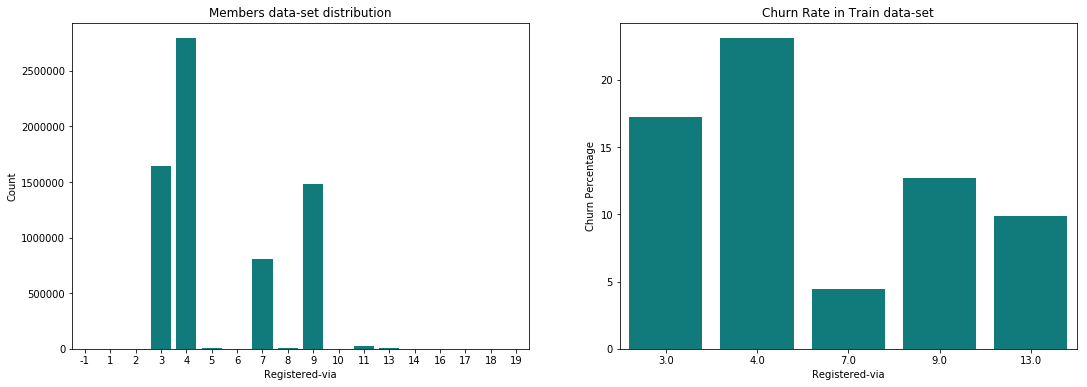

In [23]:
plt.figure(figsize=(18,6))
plt.subplot(121)
members['registered_via'] = members['registered_via'].fillna('Missing')
sns.countplot(x="registered_via", data=members, color = 'darkcyan')
plt.title('Members data-set distribution')
plt.xlabel('Registered-via')
plt.ylabel('Count')

plt.subplot(122)
d = x1.groupby(['registered_via', 'is_churn'])['msno'].count().reset_index()
d = pd.pivot_table(d, index = 'registered_via', columns = 'is_churn', values = 'msno', aggfunc = np.sum)
d['registered_via_churn_percentage'] = (d[1]/(d[1] + d[0])) * 100
d = d.reset_index()
sns.barplot(x = 'registered_via', y = 'registered_via_churn_percentage', data = d, color = 'darkcyan')
plt.title('Churn Rate in Train data-set')
plt.xlabel('Registered-via')
plt.ylabel('Churn Percentage')
plt.savefig('Registered-via.png')
plt.show()

There are 5 classes('3', '4', '7', '9', '13') listed as registration method in x1. There are also some additional classes in the members dataset. As we merged the train and members they are missing. Also there are noticeable differences in terms of registration method. Method “7” appears to correlated with the most loyal users, while method “4” has slightly higher churn rate of all.

# How are the registration trends yearly & monthly? (members)

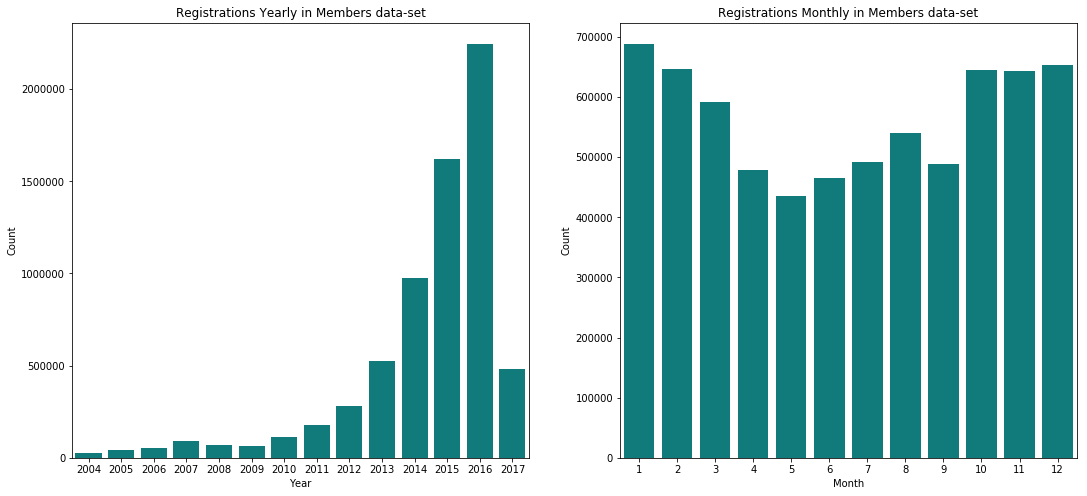

In [24]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.countplot(x="registration_init_year", data=members, color = 'darkcyan')
plt.title('Registrations Yearly in Members data-set')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(122)
sns.countplot(x="registration_init_month", data=members, color = 'darkcyan')
plt.title('Registrations Monthly in Members data-set')
plt.xlabel('Month')
plt.ylabel('Count')
plt.savefig('Registration trends yearly & monthly.png')
plt.show()

Here we observe that popularity started rising slowly after 2009 and it started to increase strongly from 2012. Registrations are high during the year end(oct, nov, dec) and year starting months(jan, feb).

# How are the churning trends yearly and monthly? (x1)

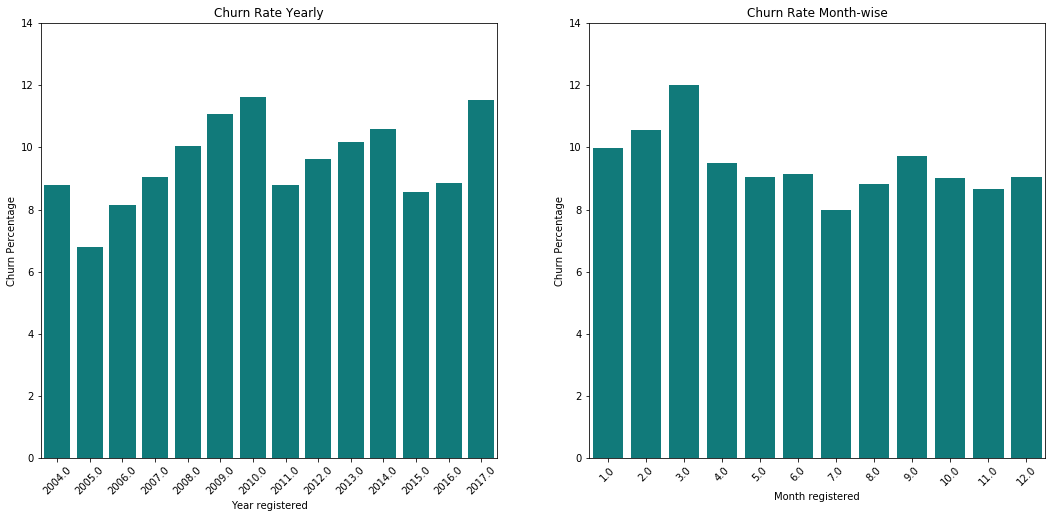

In [25]:
plt.figure(figsize=(18,8))

plt.subplot(121)
e = x1.groupby(['registration_init_year', 'is_churn'])['msno'].count().reset_index()
e = pd.pivot_table(e, index = 'registration_init_year', columns = 'is_churn', values = 'msno', aggfunc = np.sum)
e['churn_percentage_yearly'] = (e[1]/ (e[0] + e[1])) * 100
e = e.reset_index()
sns.barplot(x = 'registration_init_year', y = 'churn_percentage_yearly', data = e, color = 'darkcyan')
plt.ylim(0,14)
plt.xticks(rotation = 45)
plt.xlabel('Year registered')
plt.ylabel('Churn Percentage')
plt.title('Churn Rate Yearly')

plt.subplot(122)
f = x1.groupby(['registration_init_month', 'is_churn'])['msno'].count().reset_index()
f = pd.pivot_table(f, index = 'registration_init_month', columns = 'is_churn', values = 'msno', aggfunc = np.sum)
f['churn_percentage_monthly'] = (f[1]/ (f[0] + f[1])) * 100
f = f.reset_index()
sns.barplot(x = 'registration_init_month', y = 'churn_percentage_monthly', data = f, color = 'darkcyan')
plt.ylim(0,14)
plt.xticks(rotation = 45)
plt.xlabel('Month registered')
plt.ylabel('Churn Percentage')
plt.title('Churn Rate Month-wise')
plt.savefig('Churning trends yearly and monthly.png')
plt.show()

The churn rate doesn't seem to follow a trend. It'|s been consistent and fluctuating between 8% to 12% regardless of increase in number of registrations every year.

# Data Exploration in x2 (merged data set of train and transactions)

In [26]:
x2 = pd.merge(train, transactions, on = 'msno', how = 'left')

# Which Payment method-id is most used ? & Payment method-id vs CHURN 

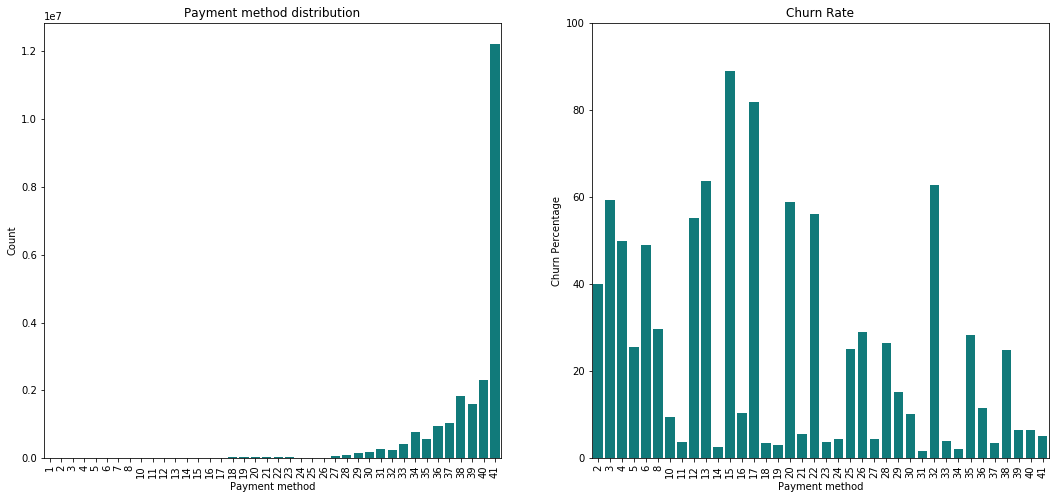

In [27]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.countplot(x="payment_method_id", data=transactions, color = 'darkcyan')
plt.xticks(rotation = 90)
plt.xlabel('Payment method')
plt.ylabel('Count')
plt.title('Payment method distribution')

plt.subplot(122)
df1 = x2.groupby(['payment_method_id', 'is_churn'])['msno'].count().reset_index()
df1 = pd.pivot_table(df1, index = 'payment_method_id', columns = 'is_churn', values = 'msno', aggfunc = np.sum)
df1['churn_percentage'] = (df1[1]/ (df1[0] + df1[1])) * 100
df1 = df1.reset_index()
sns.barplot(x = 'payment_method_id', y = 'churn_percentage', data = df1, color = 'darkcyan')
plt.xticks(rotation = 90)
plt.title('Churn Rate')
plt.xlabel('Payment method')
plt.ylabel('Churn Percentage')
plt.ylim(0,100)
plt.savefig('Payment method.png')
plt.show()

There are 40 payment methods (method '9' is missing) and the payment_method '41' is by far the most popular one. 

Some payment_methods are clearly associated to more loyal users than others. Note that several categories suffer from low-number statistics and the corresponding large churn rate bars. However, the vastly popular payment method “41” is easily in the top 10 of lowest churn.

# Which payment plan is mostly used? & Payment plan days Vs CHURN 

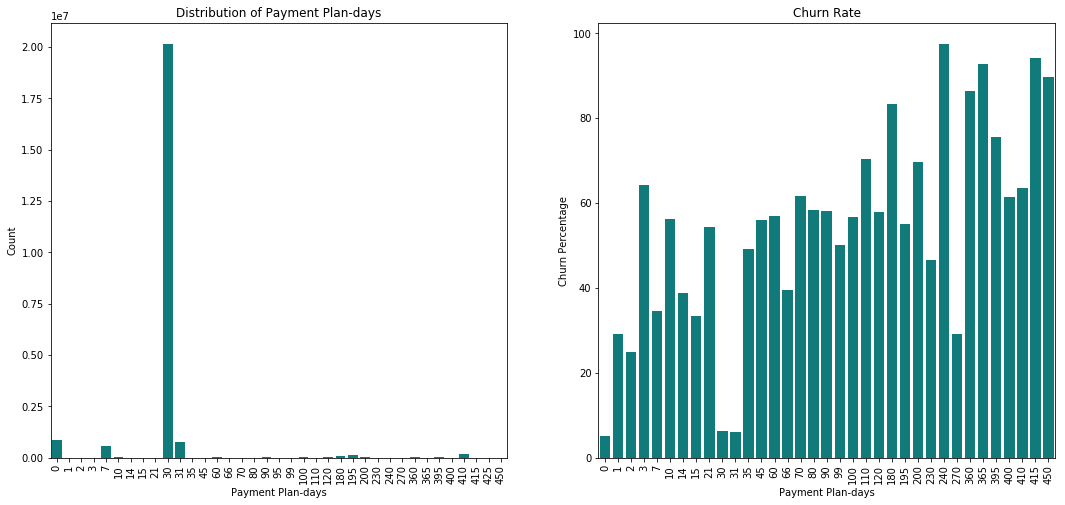

In [28]:
plt.figure(figsize=(18,8))
plt.subplot(121)
sns.countplot(x="payment_plan_days", data=transactions, color = 'darkcyan')
plt.xlabel('Payment Plan-days')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Distribution of Payment Plan-days')

plt.subplot(122)
df2 = x2.groupby(['payment_plan_days', 'is_churn'])['msno'].count().reset_index()
df2 = pd.pivot_table(df2, index = 'payment_plan_days', columns = 'is_churn', values = 'msno', aggfunc = np.sum)
df2['churn_percentage'] = (df2[1]/ (df2[0] + df2[1])) * 100
df2 = df2.reset_index()
sns.barplot(x = 'payment_plan_days', y = 'churn_percentage', data = df2, color = 'darkcyan')
plt.xlabel('Payment Plan-days')
plt.xticks(rotation = 90)
plt.ylabel('Churn Percentage')
plt.title('Churn Rate')
plt.savefig('Payment Plan-days.png')
plt.show()

The payment_plan_duration categories show strong differences in churn percentage. The lowest churn numbers(around 5%) are associated with the 30-days, 31-days, and the 0-day memberships(surprisingly). The churn percentage for next widely used plans 7-days is 35% & 410-days is 63%. For this feature as well, there are categories with low number statistics and large churn rate bars.

# Are the users paying according to their plan list price?

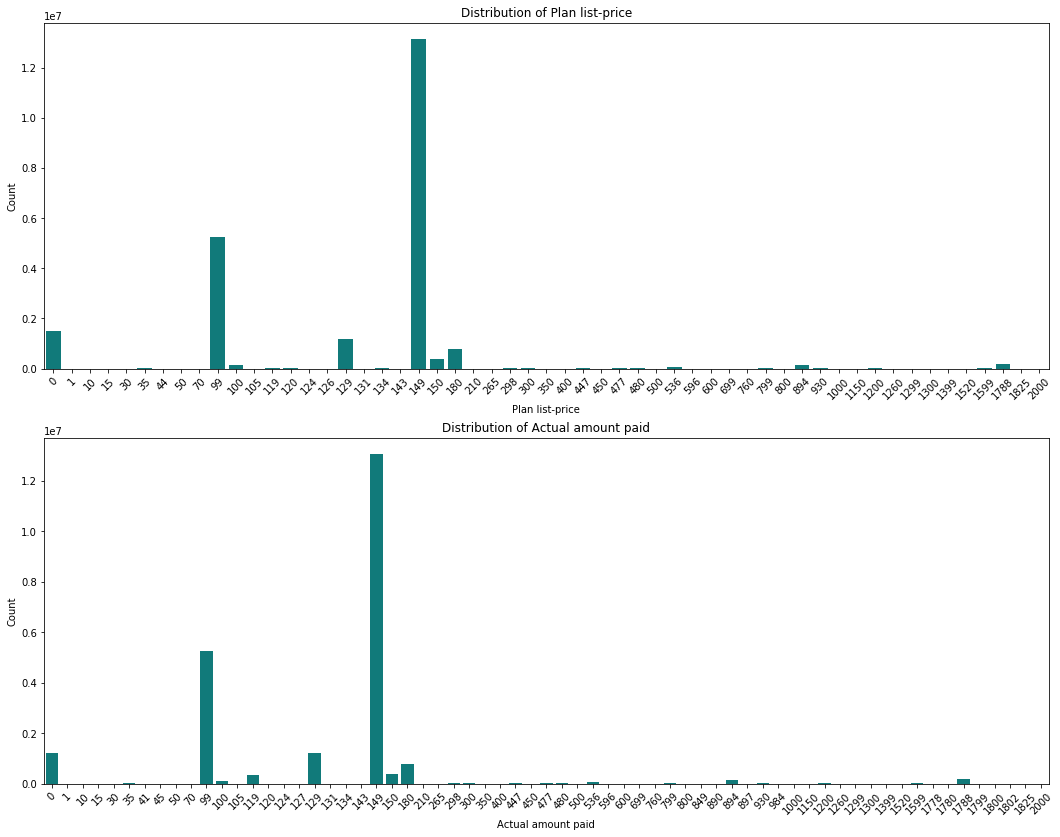

In [29]:
plt.figure(figsize=(18,14))
plt.subplot(211)
sns.countplot(x="plan_list_price", data=transactions, color = 'darkcyan')
plt.xlabel('Plan list-price')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Distribution of Plan list-price')

plt.subplot(212)
sns.countplot(x="actual_amount_paid", data=transactions, color = 'darkcyan')
plt.xlabel('Actual amount paid')
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.title('Distribution of Actual amount paid')
plt.savefig('list price vs price paid.png')
plt.show()

The overall distributions of planned vs actual payment are very similar, even though differences are slightly visible e.g. for 119 NTD. Since both features have the same discrete payment values we can directly compare their frequency.

# Is the Actual amount paid = plan list price ? Let's see!!!

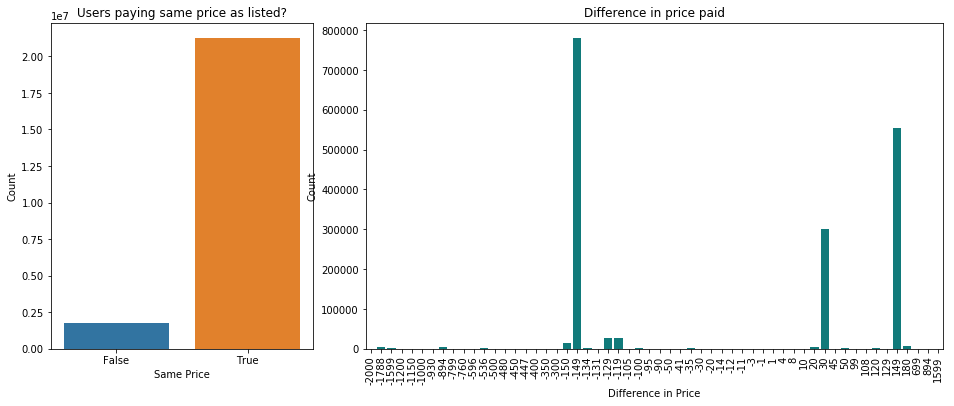

In [30]:
same_price = transactions['plan_list_price'] == transactions['actual_amount_paid']
diff_price = transactions['plan_list_price'] - transactions['actual_amount_paid'] 
diff_price = diff_price[diff_price !=0]

plt.figure(figsize=(16,6))
gridspec.GridSpec

plt.subplot2grid((3,3),(0,0), rowspan = 3)
sns.countplot(same_price)
plt.xlabel('Same Price')
plt.ylabel('Count')
plt.title('Users paying same price as listed?')

plt.subplot2grid((3,3),(0,1), rowspan = 3, colspan = 2)
sns.countplot(diff_price, color = 'darkcyan')
plt.xlabel('Difference in Price')
plt.xticks(rotation = 'vertical')
plt.ylabel('Count')
plt.title('Difference in price paid')
plt.savefig('Actual amount paid = plan list price ?.png')
plt.show()

Interestingly here, in most of the cases the users ended up paying more.

# Churn rate of users who paid more.

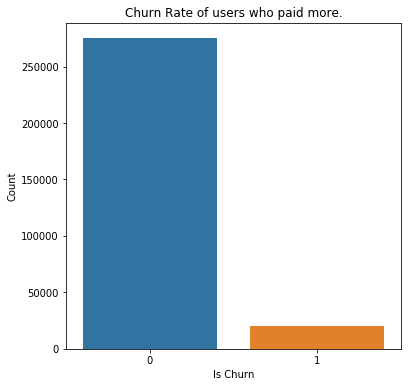

Churn Percentage: 6.869043106249323


In [31]:
plt.figure(figsize = (6,6))
paid_more = x2[x2['plan_list_price'] - x2['actual_amount_paid'] < 0]
paid_more = paid_more[['msno', 'is_churn']]
paid_more = paid_more.groupby('msno')['is_churn'].max().reset_index()
sns.countplot(x = 'is_churn', data = paid_more)
plt.xlabel('Is Churn')
plt.ylabel('Count')
plt.title('Churn Rate of users who paid more.')
plt.savefig('Churn rate of users who paid more.png')
plt.show()

print('Churn Percentage: ' + str(20295/295456 * 100))

There isn't any surprising trend in churn rate of users who paid more.

#  Auto-renew Vs CHURN

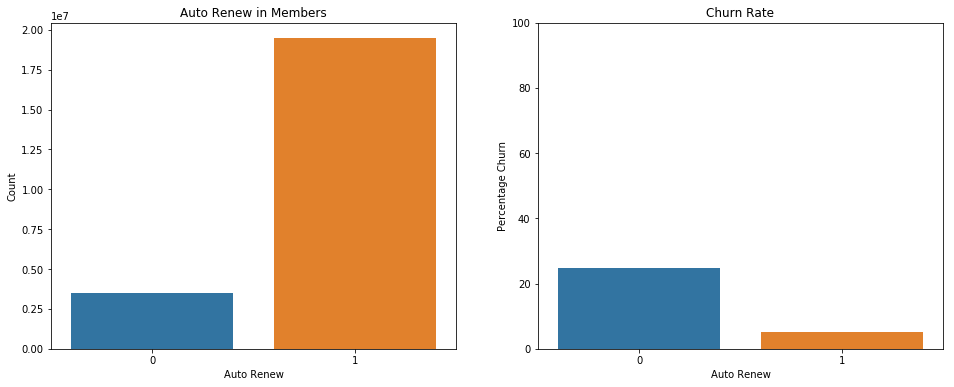

In [32]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.countplot(x="is_auto_renew", data=transactions)
plt.xlabel('Auto Renew')
plt.ylabel('Count')
plt.title('Auto Renew in Members')

plt.subplot(122)
df3 = x2.groupby(['is_auto_renew', 'is_churn'])['msno'].count().reset_index()
df3 = pd.pivot_table(df3, index = 'is_auto_renew', columns = 'is_churn', values = 'msno')
df3['churn_rate'] = (df3[1]/ (df3[0] + df3[1])) * 100
df3 = df3.reset_index()
sns.barplot(x = 'is_auto_renew', y = 'churn_rate', data = df3)
plt.xlabel('Auto Renew')
plt.ylabel('Percentage Churn')
plt.title('Churn Rate')
plt.ylim(0,100)
plt.savefig('Auto Renew.png')
plt.show()

The vast majority of users have automatic renewal of their subscriptions enabled and users who did not choose to auto_renew were clearly more likely to churn.

# Cancellation trend (transactions)

In [33]:
cancel_date = pd.DataFrame(transactions[transactions['is_cancel']==1][['is_cancel','transaction_date_year', 'transaction_date_month', 'transaction_date_date']])
cancel_date = pd.DataFrame(cancel_date.groupby(['transaction_date_year', 'transaction_date_month', 'transaction_date_date'])['is_cancel'].count()).reset_index()
cancel_date['DateTime'] = cancel_date[['transaction_date_year', 'transaction_date_month', 'transaction_date_date']].apply(lambda s : datetime.datetime(*s),axis = 1)

cancel_month = pd.DataFrame(transactions[transactions['is_cancel']==1][['is_cancel', 'transaction_date_month']])
cancel_month = pd.DataFrame(cancel_date.groupby(['transaction_date_month'])['is_cancel'].sum()).reset_index()

cancel_year = pd.DataFrame(transactions[transactions['is_cancel']==1][['is_cancel', 'transaction_date_year']])
cancel_year = pd.DataFrame(cancel_date.groupby(['transaction_date_year'])['is_cancel'].sum()).reset_index()

### Cancellations daily

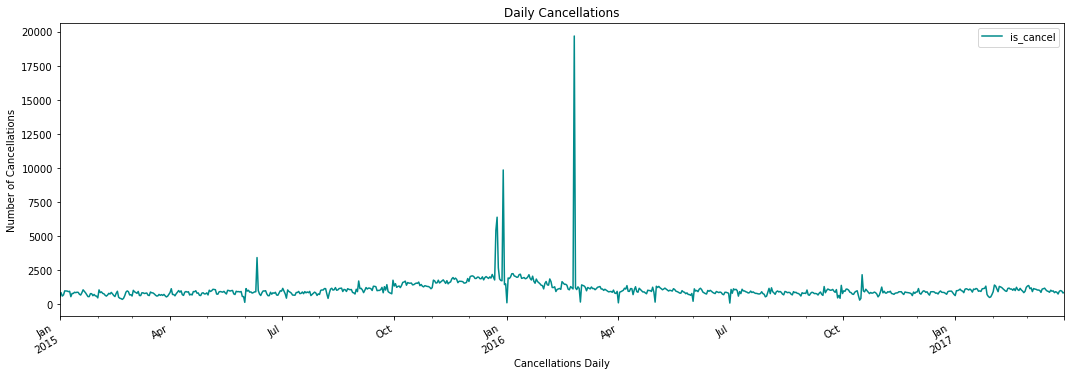

In [34]:
cancel_date.plot(x='DateTime', y='is_cancel', figsize = (18,6), subplots = (131), color = 'darkcyan')
plt.xlabel('Cancellations Daily')
plt.ylabel('Number of Cancellations')
plt.title('Daily Cancellations')
plt.savefig('Daily Cancellations.png')
plt.show()

The daily cancellation trend seems quite consistent overall with a couple of spikes in jan & mar 2016.

### Cancellations monthly

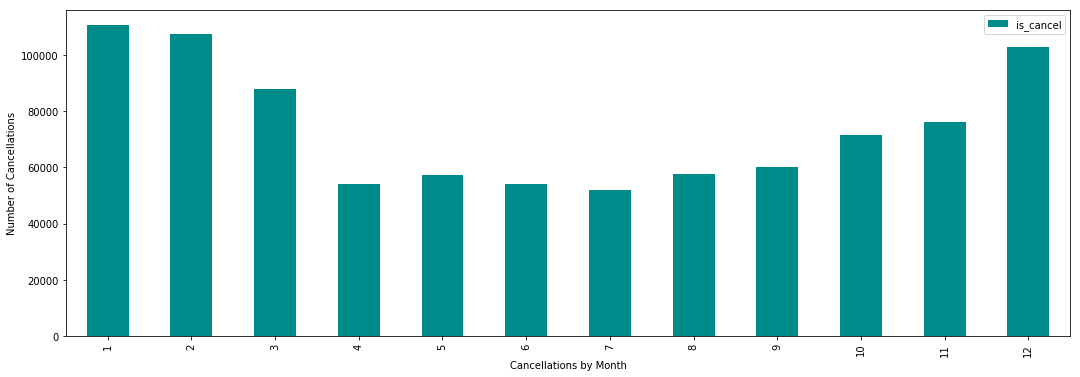

In [35]:
cancel_month.plot(x = 'transaction_date_month', y = 'is_cancel', kind = 'bar', figsize = (18,6), color = 'darkcyan')
plt.xlabel('Cancellations by Month')
plt.ylabel('Number of Cancellations')
plt.savefig('Monthly Cancellations.png')
plt.show()

Cancellations are high in the months of dec, jan, feb & mar. Rest all the months seem similar.

# Do all the users who cancel their subscription churning???

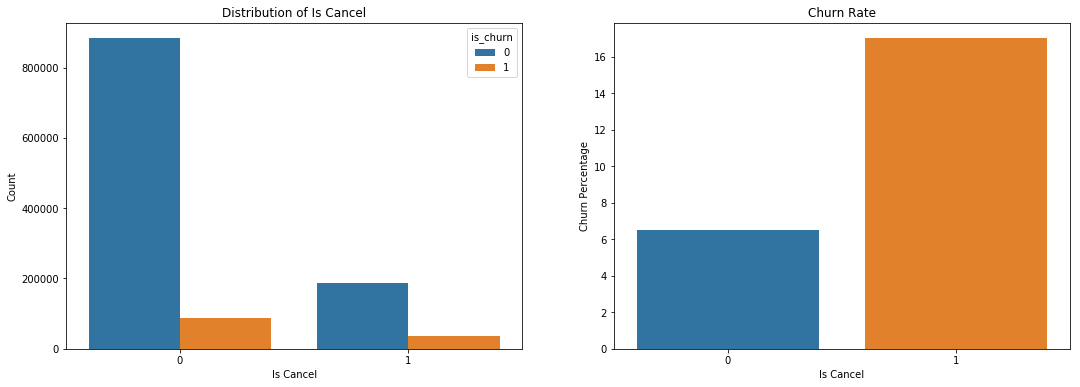

In [36]:
plt.figure(figsize = (18,6))
plt.subplot(121)
churn_cancel = pd.DataFrame(x2.groupby(['msno','is_cancel'])['is_churn'].max()).reset_index()
sns.countplot(x="is_cancel", hue = 'is_churn', data=churn_cancel)
plt.xlabel('Is Cancel')
plt.ylabel('Count')
plt.title('Distribution of Is Cancel')
           
plt.subplot(122)
cc = x2.groupby(['is_cancel','is_churn'])['msno'].count().reset_index()
cc = pd.pivot_table(cc, index = 'is_cancel', columns = 'is_churn', values = 'msno')
cc['churn_rate'] = (cc[1]/ (cc[0] + cc[1])) * 100
cc = cc.reset_index()
sns.barplot(x = 'is_cancel', y = 'churn_rate', data = cc)
plt.xlabel('Is Cancel')
plt.ylabel('Churn Percentage')
plt.title('Churn Rate')
plt.savefig('DDistribution of Is Cancel.png')
plt.show()

Not all users who cancelled their subscription are churning. Majority of the cancelled users are re-subscribing within a month

# Data Exploration in x3 (merged data set of train and userlogs)

In [37]:
x3 = pd.merge(train, user_logs, on = 'msno', how = 'left')

In [38]:
x3.head()

,msno,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,date_year,date_month,date_date
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,7.0,0.0,3.0,5.0,71.0,68.0,17599.893,2017.0,3.0,5.0
1,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,138.0,19.0,7.0,1.0,21.0,158.0,8830.433,2017.0,3.0,1.0
2,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0.0,0.0,0.0,0.0,34.0,17.0,7883.313,2017.0,3.0,19.0
3,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,15.0,0.0,0.0,1.0,38.0,17.0,9029.227,2017.0,3.0,16.0
4,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0.0,0.0,0.0,0.0,8.0,8.0,1870.110,2017.0,3.0,10.0


# Life span of Churn users vs No-Churn users.

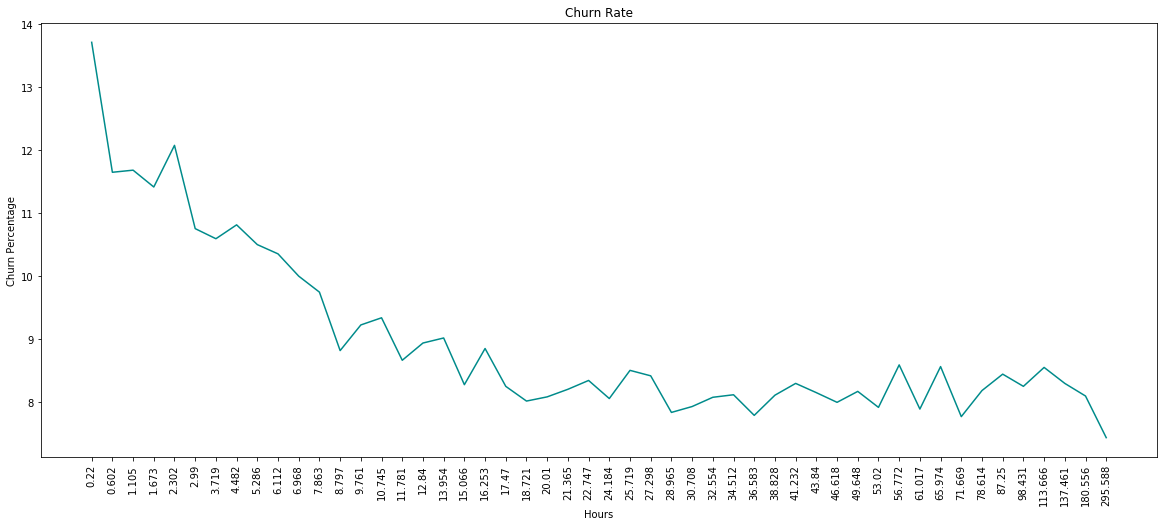

In [39]:
f = {'total_secs':['sum'], 'is_churn':['min']}
a1 = x3[pd.isnull(x3['total_secs'])==False].groupby('msno').agg(f)
a1.columns = a1.columns.droplevel()
a1.columns = ['total_secs_sum', 'is_churn']
a1['total_hours'] = a1.total_secs_sum/3600

array_ = np.sort(a1['total_hours'])
start = 0
stop = len(array_)
step = 15000
bins = array_[start:stop:step]
def churn_percentage(mi,mx):
    hour = a1[(a1['total_hours'] > mi) & (a1['total_hours'] < mx)]
    hour_nc = len(hour[hour['is_churn'] == 0]) 
    hour_c = len(hour[hour['is_churn'] == 1])
    churn_percentage = (hour_c/ (hour_c + hour_nc)) * 100
    return churn_percentage

CP = []
bin_names = []
for i in range(0,len(bins)-1):
    CP.append(churn_percentage(bins[i],bins[i+1]))
    bin_names.append(str(round(bins[i+1],3)))
    i = i+1
    

plt.figure(figsize = (20,8))
plt.xlabel('Hours')
plt.xticks(np.arange(0,len(bins)-1), bin_names, rotation = 90)
plt.ylabel('Churn Percentage')
plt.title('Churn Rate')
plt.plot( np.arange(0,len(bins)-1) , CP, color = 'darkcyan')
plt.savefig('Lifespan in hours Vs Churn-rate.png')
plt.show()

Users with less life span are slightly churning more.

# Mean & Median of sum of all songs by Churn users Vs No-Churn users.

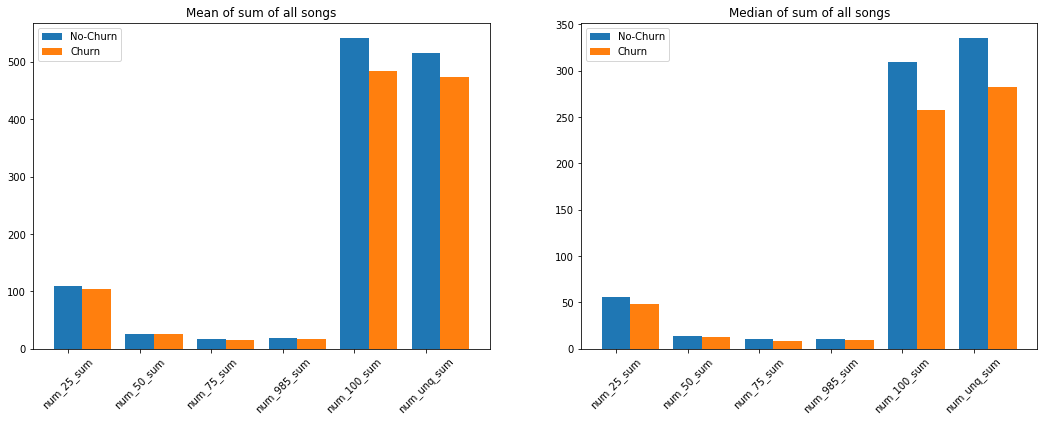

In [40]:
f = {'is_churn':['max'],'num_25':['sum'],
    'num_50':['sum'],'num_75':['sum'],'num_985':['sum'],'num_100':['sum'],'num_unq':['sum']}
all_mean = x3.groupby('msno').agg(f)
all_mean.columns = all_mean.columns.droplevel()
all_mean.columns = ['is_churn','num_25_sum','num_50_sum',
                   'num_75_sum','num_985_sum','num_100_sum','num_unq_sum']

churn_users = all_mean[all_mean['is_churn'] == 1]
not_churn_users = all_mean[all_mean['is_churn'] == 0]
churn_users = churn_users.drop(['is_churn'], 1)
not_churn_users = not_churn_users.drop(['is_churn'], 1)

plt.figure(figsize=(18,6))
plt.subplot(121)
width = 0.4
plt.bar( np.arange(0,6) , not_churn_users.mean(), width=width, label = 'No-Churn')
plt.bar( np.arange(0,6) + width , churn_users.mean() , width, label = 'Churn')
plt.xticks(np.arange(6), list(churn_users), rotation = '45')
plt.legend(loc = 'upper left')
plt.title('Mean of sum of all songs')

plt.subplot(122)
width = 0.4
plt.bar( np.arange(0,6) , not_churn_users.median(), width=width, label = 'No-Churn')
plt.bar( np.arange(0,6) + width , churn_users.median() , width, label = 'Churn')
plt.xticks(np.arange(6), list(churn_users), rotation = '45')
plt.legend(loc = 'upper left')
plt.title('Median of sum of all songs')

plt.savefig('sum of all songs by Churn users Vs No-Churn users')
plt.show()

# Testing significance for above plot.

Null - Hypothesis : There is no difference between mean number of songs played by churn users vs nonchurn users.

In [41]:
from scipy.stats import ttest_ind
itercol = ['num_25_sum','num_50_sum','num_75_sum','num_985_sum','num_100_sum','num_unq_sum']
res = [ttest_ind(churn_users[X].dropna(),not_churn_users[X].dropna()) for X in itercol]
i=0
for X in res: 
    if (X[0] < 0) & (X[1]<0.1) :
        print('Mean number of songs listened %s percent between churn users is less than nonchurn users. '%(itercol[i][4:7])) 
    i = i+1

Mean number of songs listened 25_ percent between churn users is less than nonchurn users. 
Mean number of songs listened 50_ percent between churn users is less than nonchurn users. 
Mean number of songs listened 75_ percent between churn users is less than nonchurn users. 
Mean number of songs listened 985 percent between churn users is less than nonchurn users. 
Mean number of songs listened 100 percent between churn users is less than nonchurn users. 
Mean number of songs listened unq percent between churn users is less than nonchurn users. 


# Number of complete songs against incomplete songs

In [42]:
all_mean['incomplete_songs'] = all_mean['num_25_sum'] + all_mean['num_50_sum'] + all_mean['num_75_sum'] + all_mean['num_985_sum']
comp_incomp = all_mean[['is_churn', 'incomplete_songs', 'num_100_sum']]
comp_incomp_mean = comp_incomp.groupby('is_churn')[['incomplete_songs', 'num_100_sum']].mean().reset_index()
comp_incomp_median = comp_incomp.groupby('is_churn')[['incomplete_songs', 'num_100_sum']].median().reset_index()

### Mean & Median of complete songs Vs incomplete sonngs for churn vs not churn users.

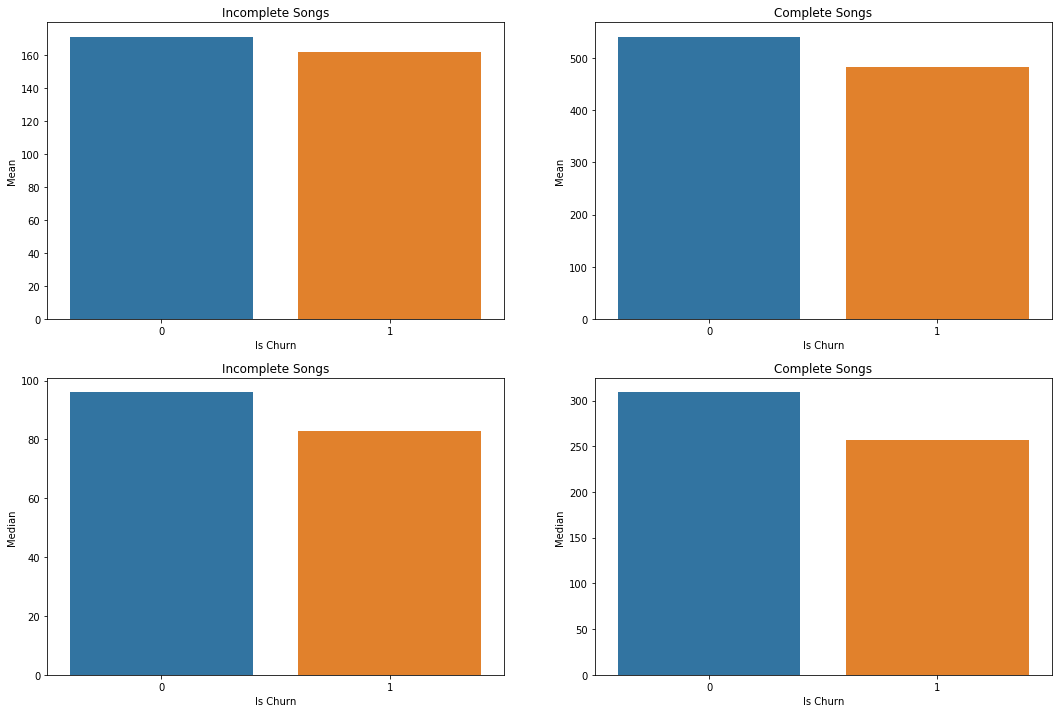

In [43]:
plt.figure(figsize = (18,12))

plt.subplot(221)
sns.barplot(x = 'is_churn',  y = 'incomplete_songs', data = comp_incomp_mean)
plt.xlabel('Is Churn')
plt.ylabel('Mean')
plt.title('Incomplete Songs')

plt.subplot(222)
sns.barplot(x = 'is_churn',  y = 'num_100_sum', data = comp_incomp_mean)
plt.xlabel('Is Churn')
plt.ylabel('Mean')
plt.title('Complete Songs')

plt.subplot(223)
sns.barplot(x = 'is_churn',  y = 'incomplete_songs', data = comp_incomp_median)
plt.xlabel('Is Churn')
plt.ylabel('Median')
plt.title('Incomplete Songs')

plt.subplot(224)
sns.barplot(x = 'is_churn',  y = 'num_100_sum', data = comp_incomp_median)
plt.xlabel('Is Churn')
plt.ylabel('Median')
plt.title('Complete Songs')

plt.savefig('Number of complete songs against incomplete songs.png')
plt.show()

# Testing significance for above plot.

Null - Hypothesis : There is no difference between mean number of complete & incomplete songs played by Churn users vs No-Churn users.

In [44]:
from scipy.stats import ttest_ind
itercol = ['incomplete_songs','num_100_sum']
itercol_s = ['incomplete songs','complete songs']
res = [ttest_ind(comp_incomp[comp_incomp['is_churn']==1][X].dropna(),
                 comp_incomp[comp_incomp['is_churn']==0][X].dropna()) for X in itercol]
i=0
for X in res: 
    if (X[0] < 0) & (X[1]<0.1) :
        print('Mean number of %s played by churn users is less than nonchurn users. '%(itercol_s[i])) 
    elif (X[0] > 0) & (X[1]<0.1) :
        print('Mean number of %s played by churn users is greater than nonchurn users. '%(itercol_s[i])) 
    i = i+1

Mean number of incomplete songs played by churn users is less than nonchurn users. 
Mean number of complete songs played by churn users is less than nonchurn users. 


Hence, it is clear from the above two plots that Churn users are listening to less number of songs when compared to No-Churn users.

# Number of days user has logged in

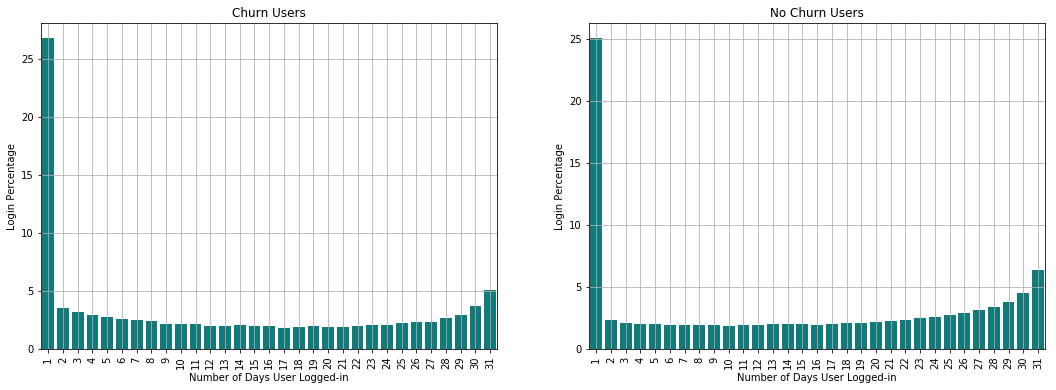

In [45]:
log_in = pd.DataFrame(x3.groupby(['msno', 'is_churn'])['msno'].size()).reset_index(drop = True)
f = {'is_churn':['min'],'msno':['count']}
log_in = x3.groupby('msno').agg(f)
log_in.columns = log_in.columns.droplevel()
log_in.columns = ['is_churn','times_user_has_logged_on']
log_in_churn = log_in[log_in.is_churn == 1]
log_in_not_churn = log_in[log_in.is_churn == 0]

log_in_churn_percentage = pd.DataFrame(log_in_churn.groupby('times_user_has_logged_on')['times_user_has_logged_on'].count())
log_in_churn_percentage['login_percentage'] = (log_in_churn_percentage['times_user_has_logged_on']/ 87330) * 100

log_in_not_churn_percentage = pd.DataFrame(log_in_not_churn.groupby('times_user_has_logged_on')['times_user_has_logged_on'].count())
log_in_not_churn_percentage['login_percentage'] = (log_in_not_churn_percentage['times_user_has_logged_on']/ 883630) * 100

plt.figure(figsize = (18,6))
plt.subplot(121)
sns.barplot(x = log_in_churn_percentage.index, y = 'login_percentage', data = log_in_churn_percentage, color = 'darkcyan')
plt.xlabel('Number of Days User Logged-in')
plt.xticks(rotation = '90')
plt.ylabel('Login Percentage')
plt.title('Churn Users')
plt.grid()

plt.subplot(122)
sns.barplot(x = log_in_not_churn_percentage.index, y = 'login_percentage', data = log_in_not_churn_percentage, color = 'darkcyan')
plt.xlabel('Number of Days User Logged-in')
plt.xticks(rotation = '90')
plt.ylabel('Login Percentage')
plt.title('No Churn Users')
plt.grid()
plt.savefig('Number of days user has logged in.png')
plt.show()

Here we observe both the Churn users & No-Churn users log-in's looks similar.